In [2]:
import sqlite3
import pandas as pd
import json
from progressbar import ProgressBar
from fastai.text import *

# Read Data

In [3]:
seed = 0
data = pd.read_csv('fastai-project/homework/data/NELA19/data_content.csv')

# Build Language Model

We tokenize and build the vocabulary

In [ ]:
data_lm = (TextList.from_df(data, cols='text')
                                .split_by_rand_pct(0.1)
                                #.label_from_df(cols='label')
                                .label_for_lm() 
                                .databunch(bs=bs))

In [ ]:
data_lm.save(path + 'data_lm.pkl')

In [ ]:
#data_lm.show_batch()
#data_lm.vocab.itos[30:40]
#data_lm.train_ds[1][0]
#data_lm.train_ds[0][0].data[:10]

In [ ]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [ ]:
data_lm.show_batch()

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, 
                                metrics=[accuracy, Perplexity()])

In [ ]:
TEXT = "The new book"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(suggestion=True)

In [58]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time


KeyboardInterrupt: 

In [61]:
learn.save('1epoch')

In [18]:
learn.load('1epoch');

In [63]:
learn.unfreeze()

In [64]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-03
Min loss divided by 10: 6.31E-08


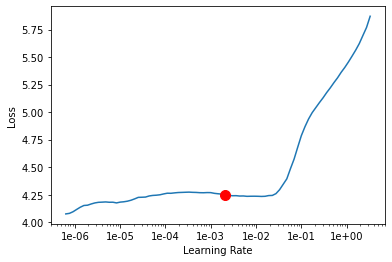

In [65]:
learn.recorder.plot(suggestion=True)

In [66]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.554946,4.450575,0.314286,85.676186,6:20:35


In [68]:
learn.save('finetuned')

In [20]:
TEXT = "The new book"
N_WORDS = 100
N_SENTENCES = 1
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The new book is a sort of English - language book , authors : The New York Times   published the story of a man who has had a “ Jewish ” history , and a new book by David Flights , with a new book called The Man Who Dies Out , which has been published on   France Global . 
 
  The book , titled “ The First Time in American History , ” includes a sentence of  


In [19]:
learn.load('finetuned');

In [21]:
learn.save_encoder('finetuned_enc')

# Bias Classifier

In [ ]:
data_bb = (TextList.from_df(data, cols=['title','content'],  vocab=data_lm.vocab)
                                .split_by_rand_pct(0.1)
                                .label_from_df(cols='bias')
                                .databunch(bs=bs))

In [ ]:
data_bb.save(path + 'data_bb.pkl')

In [6]:
data_bb = load_data(path, 'data_bb.pkl', bs=bs)

In [7]:
data_bb.show_batch()

text,target
"xxbos xxmaj archive : ' xxmaj this xxmaj week ' xxmaj transcripts xxmaj below are links to transcripts of previous "" xxmaj this xxmaj week with xxmaj george xxmaj stephanopoulos "" episodes . xxmaj head to our homepage for our more recent show transcripts . \n \n xxmaj you can see full video of past programs xxup here . \n \n xxmaj like "" xxmaj this xxmaj week",left_center_bias
"xxbos xxmaj when xxmaj they xxmaj want xxmaj war , xxmaj india and xxmaj pakistan xxmaj will xxmaj always xxmaj have xxmaj kashmir xxmaj when this series was first published in xxmaj the xxmaj daily xxmaj beast last xxmaj december , i had no idea that xxmaj kashmir was about to explode — quite literally — into the headlines again . \n \n xxmaj there had been numerous developments",left_bias
xxbos xxmaj lt . xxmaj gen. xxmaj ben xxmaj hodges on xxmaj iraq : ' i xxmaj never xxmaj dreamed xxmaj that xxmaj we xxmaj would xxmaj still xxmaj be xxmaj involved ' xxmaj sputnik : xxmaj what did you know about the situation in xxmaj iraq before you went there and what did you know and thought about xxmaj saddam xxmaj hussein ? xxmaj what,right_center_bias
"xxbos xxmaj the xxmaj french xxmaj economist xxmaj who xxmaj helped xxmaj invent xxmaj elizabeth xxmaj warren ’s xxmaj wealth xxmaj tax xxmaj to trace the progress of the wealth tax from a fringe academic idea to the center of the xxmaj democratic xxmaj presidential primary , it is helpful to begin a bit off - center . xxmaj on xxmaj september 15 , 2008 , the day that xxmaj",left_bias
xxbos xxmaj uganda v xxmaj egypt : xxmaj african xxmaj cup of xxmaj nations – live ! [ xxunk xxup edt xxunk ] ( / football / live / 2019 / jun / 30 / uganda - v - egypt - african - cup - of- \n nations - live?page = with : xxunk # block- \n xxunk ) \n \n # # xxmaj half - time,left_center_bias


In [8]:
learn = text_classifier_learner(data_bb, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('finetuned_enc');

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 2.09E-02


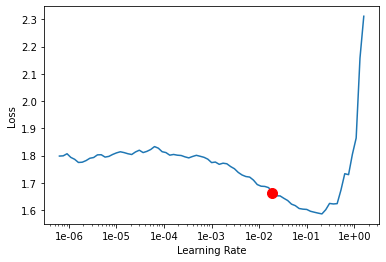

In [27]:
learn.recorder.plot(suggestion=True)

In [6]:
learn.fit_one_cycle(1, 2e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [7]:
learn.save('bias_1epoch')

In [9]:
learn.load('bias_1epoch');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save('bias_f_1epoch')

In [ ]:
learn.load('bias_f_1epoch');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save('bias_f_2epoch')

In [ ]:
learn.predict("I really loved that movie, it was awesome!")